In [45]:
import numpy as np
import matplotlib.pyplot as plt
from os import path

from utils.colors import C
from fenics import *
from utils.mesh_utils import get_square_f
from utils.utils import progress_bar
from algorithms.matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver

In [56]:
def compute_times_across_k(n, lower, upper, step, repeats):
    # Create the mesh
    mesh = UnitSquareMesh(n, n)
    V_h = FunctionSpace(mesh, 'CG', 1)
    rsvd = MatrixFreeRSVD(V_h)

    k_range = np.arange(lower, upper, step)
    n_k = len(k_range)

    # Check if file exits already
    file_name = f"../results/n_{n}_k_{lower}_{upper}_{step}_r_{repeats}.npy"
    if path.exists(file_name):
        print("Returning existing file:", file_name)
        times = np.load(file_name)
        return times, k_range

    # (repeats, k_range, 4 time points)
    times = np.zeros((repeats, n_k, 4))

    for r in range(repeats):
        for i, k in enumerate(k_range):
            rsvd.mf_rsvd(k)
            times[r, i, :] = rsvd.times
            progress_bar(r * n_k + i + 1, repeats * n_k, end_text=f' (k={k}, N_b={rsvd.N_b})')

    return times, k_range


def plot_times_across_k(x_axis, times, x_label='Target rank $k$'):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    ax1, ax2 = axes

    ax1.plot(x_axis, times[:, 0], label='1. $Y$', c=C.c5[0])
    ax1.plot(x_axis, times[:, 1], label='2. $QR = Y$', c=C.c5[1])
    ax1.plot(x_axis, times[:, 2], label='3. $B = Q^T K$', c=C.c5[2])
    ax1.plot(x_axis, times[:, 3], label='4. $U \Sigma V^T$', c=C.c5[3])

    ax2.stackplot(
        x_axis,
        times[:, 0], times[:, 1], times[:, 2], times[:, 3],
        labels=['1. $Y$', '2. $QR = Y$', '3. $B = Q^T K$', '4. $U \Sigma V^T$'],
        alpha=0.8,
        colors=[C.c5[0], C.c5[1], C.c5[2], C.c5[3]]
    )

    ax1.set_xlabel(x_label)
    ax2.set_xlabel(x_label)
    ax1.set_ylabel("Computation time [s]")

    ax1.legend()
    ax2.legend()
    ax1.grid()
    ax2.grid()

    plt.tight_layout()
    plt.show()

Returning existing file: ../results/n_128_k_5_505_5_r_5.npy


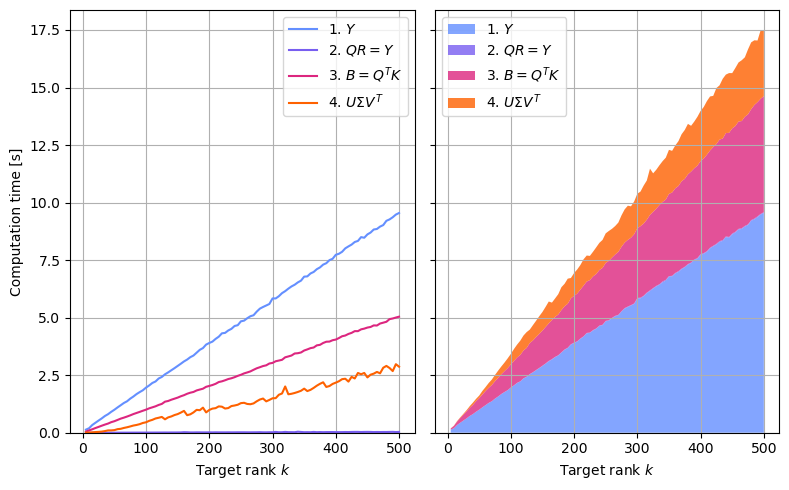

In [57]:
times, k_range = compute_times_across_k(n=128, lower=5, upper=505, step=5, repeats=5)

times_median = np.median(times, axis=0)
plot_times_across_k(k_range, times_median)

Returning existing file: ../results/n_256_k_10_1025_25_r_5.npy


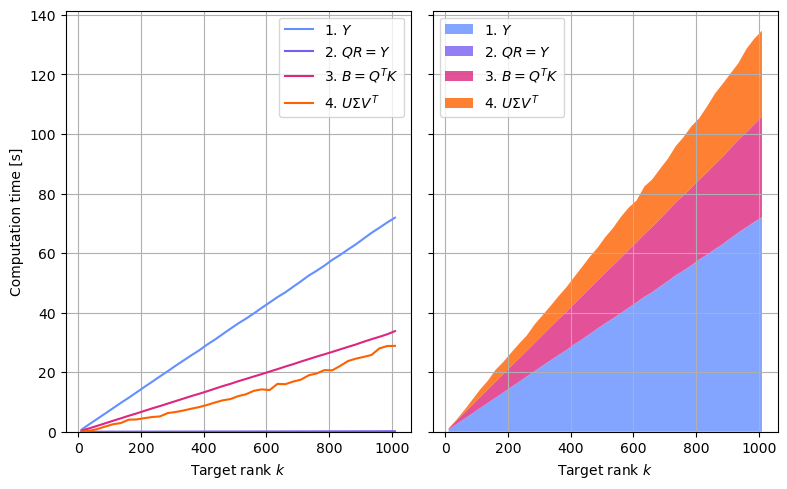

In [63]:
times, k_range = compute_times_across_k(n=256, lower=10, upper=1025, step=25, repeats=5)

times_median = np.median(times, axis=0)
plot_times_across_k(k_range, times_median)

In [26]:
def compute_times_across_N(k, lower=32, upper=272, step=16, repeats=5):
    times = []
    n_range = np.arange(lower, upper, step)
    N_range = []
    N_b_range = []

    n_n = len(n_range)
    times = np.zeros((repeats, n_n, 4))
    for r in range(repeats):
        for i, n in enumerate(n_range):
            mesh = UnitSquareMesh(n, n)
            V_h = FunctionSpace(mesh, 'CG', 1)
            rsvd = MatrixFreeRSVD(V_h)

            if r == 0:
                N, N_b = rsvd.N, rsvd.N_b
                N_range.append(N)
                N_b_range.append(N_b)

            rsvd.mf_rsvd(k)
            times[r, i, :] = rsvd.times
            progress_bar(r * n_n + i + 1, repeats * n_n, end_text=f' (k={k}, n={n})')

    return times, N_b_range, N_range


times, N_b_range, N_range = compute_times_across_N(
    k=25, lower=16, upper=1016, step=16, repeats=5
)
np.save("../results/N_16_1016_16_r_5.npy", times)
times_median = np.median(times, axis=0)

[##############################] 315/315 (k=25, n=1008)


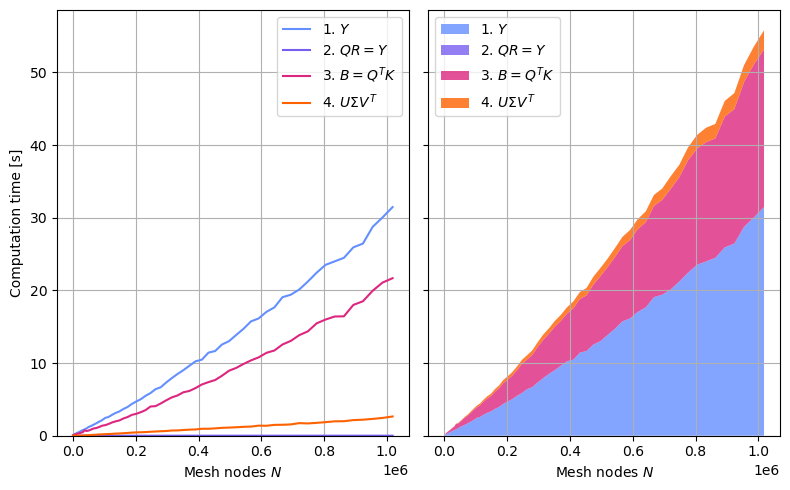

In [27]:
def plot_times_across_N(x_axis, times, x_label='Mesh nodes $N$'):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    ax1, ax2 = axes
    
    ax1.plot(x_axis, times[:, 0], label='1. $Y$', c=C.c5[0])
    ax1.plot(x_axis, times[:, 1], label='2. $QR = Y$', c=C.c5[1])
    ax1.plot(x_axis, times[:, 2], label='3. $B = Q^T K$', c=C.c5[2])
    ax1.plot(x_axis, times[:, 3], label='4. $U \Sigma V^T$', c=C.c5[3])

    ax2.stackplot(
        x_axis,
        times[:, 0], times[:, 1], times[:, 2], times[:, 3],
        labels=['1. $Y$', '2. $QR = Y$', '3. $B = Q^T K$', '4. $U \Sigma V^T$'],
        alpha=0.8,
        colors=[C.c5[0], C.c5[1], C.c5[2], C.c5[3]]
    )

    ax1.set_xlabel(x_label)
    ax2.set_xlabel(x_label)
    ax1.set_ylabel("Computation time [s]")

    ax1.legend()
    ax2.legend()
    ax1.grid()
    ax2.grid()

    plt.tight_layout()
    plt.show()


plot_times_across_N(N_range, times_median)